## Check python requirements
 - Python version between 3.8 and 3.11
 - urllib3==1.25.*

## Imports

In [7]:
import kagglehub
import os
import shutil
import random
import matplotlib.pyplot as plt
from datetime import datetime

c:\Users\Uzivatel\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint

## Download image dataset

In [4]:
# Download latest version
path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", path)
path = path + r"\plantvillage dataset" + r"\color"

Path to dataset files: C:\Users\Uzivatel\.cache\kagglehub\datasets\abdallahalidev\plantvillage-dataset\versions\3


## Split dataset into train, validation and test data

In [5]:

# Paths
original_dataset_dir = path  # Path to the original dataset
output_base_dir = 'split_dataset'  # Output directory for train, val, test

if not os.path.isdir(output_base_dir):

    # Create train, val, test directories
    splits = ['train', 'validation', 'test']
    for split in splits:
        split_path = os.path.join(output_base_dir, split)
        os.makedirs(split_path, exist_ok=True)

    # Split ratios
    train_ratio = 0.7
    val_ratio = 0.2
    test_ratio = 0.1

    # Split images
    for class_name in os.listdir(original_dataset_dir):
        class_path = os.path.join(original_dataset_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        # Create class directories in each split folder
        for split in splits:
            os.makedirs(os.path.join(output_base_dir, split, class_name), exist_ok=True)

        # Get all image files
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        random.shuffle(images)

        # Calculate split sizes
        total_images = len(images)
        train_size = int(total_images * train_ratio)
        val_size = int(total_images * val_ratio)

        # Assign images to splits
        train_images = images[:train_size]
        val_images = images[train_size:train_size + val_size]
        test_images = images[train_size + val_size:]

        # Function to copy images
        def copy_images(image_list, split):
            for image in image_list:
                src = os.path.join(class_path, image)
                dest = os.path.join(output_base_dir, split, class_name, image)
                shutil.copy(src, dest)

        # Copy images to respective folders
        copy_images(train_images, 'train')
        copy_images(val_images, 'validation')
        copy_images(test_images, 'test')

    print("Dataset successfully split!")

else:
    print(f"Folder {output_base_dir} already exists")


Folder split_dataset already exists


## Load images into code

In [10]:
# Define paths
train_dir = 'split_dataset/train'
validation_dir = 'split_dataset/validation'
test_dir = 'split_dataset/test'

# Load datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),  # Resize all images to this size
    batch_size=32          # Number of images per batch
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(224, 224),
    batch_size=32
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32
)

# Optional: Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


Found 37997 files belonging to 38 classes.
Found 10849 files belonging to 38 classes.
Found 5459 files belonging to 38 classes.


## Data augmentation and normalization
- Creates random variations for train set to prevent overfitting and make robust model
- Rescales image values from 0-255 to 0-1

In [11]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
])

# Normalize the dataset
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))
train_dataset = train_dataset.map(lambda x, y: (Rescaling(1./255)(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (Rescaling(1./255)(x), y))
test_dataset = test_dataset.map(lambda x, y: (Rescaling(1./255)(x), y))


## Model definition

In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [ ]:
# Get numbert of output classes (number of folders in data folder)
num_of_classes = len(os.listdir("split_dataset/train"))

# Load Pre-trained Model (ResNet50)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model (initially)

# Create New Model on Top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_of_classes, activation='softmax')
])

# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [11]:
model_name = "ResNet50_v1"

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

checkpoint_filename = f"checkpoints/model_{model_name}_{timestamp}_epoch_{{epoch:02d}}_acc_{{val_accuracy:.2f}}.keras"

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filename,  # Save path
    save_weights_only=False,  # Set to True to save only weights
    save_best_only=False,     # Set to True to save only the best model
    verbose=1                 # Print a message when saving
)


history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=1,
    callbacks=[checkpoint_callback],
    batch_size=32
)

model.save(f'model/model_{model_name}_{timestamp}_epoch1_frozen_pretrained.keras')




Epoch 1/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - accuracy: 0.1162 - loss: 3.3325
Epoch 1: saving model to checkpoints/model_ResNet50_v1_20241230_144419_epoch_01_acc_0.23.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1505s 1s/step - accuracy: 0.1163 - loss: 3.3324 - val_accuracy: 0.2326 - val_loss: 3.0188
Epoch 2/10
   6/1188 ━━━━━━━━━━━━━━━━━━━━ 19:14 977ms/step - accuracy: 0.1331 - loss: 3.1674

KeyboardInterrupt: 

In [15]:
model = load_model(f'model/model_{model_name}_{timestamp}_epoch1_frozen_pretrained.keras')

# Unfreeze the base pretrained model
model.layers[0].trainable = True

# Re-compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=[checkpoint_callback],
    batch_size=32
)

model.save(f'model/model_{model_name}_{timestamp}_from_pretrained_finished.keras')


Epoch 1/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5886 - loss: 1.7104
Epoch 1: saving model to checkpoints/model_ResNet50_v1_20241230_144419_epoch_01_acc_0.58.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 5783s 5s/step - accuracy: 0.5888 - loss: 1.7097 - val_accuracy: 0.5797 - val_loss: 1.8751
Epoch 2/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9171 - loss: 0.2616
Epoch 2: saving model to checkpoints/model_ResNet50_v1_20241230_144419_epoch_02_acc_0.81.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 5668s 5s/step - accuracy: 0.9171 - loss: 0.2615 - val_accuracy: 0.8057 - val_loss: 0.7546
Epoch 3/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9368 - loss: 0.2024
Epoch 3: saving model to checkpoints/model_ResNet50_v1_20241230_144419_epoch_03_acc_0.92.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 5569s 5s/step - accuracy: 0.9368 - loss: 0.2024 - val_accuracy: 0.9243 - val_loss: 0.2440
Epoch 4/10
  66/1188 ━━━━━━━━━━━━━━━━━━━━ 1:22:38 4s/step - accuracy: 0.9643 - loss: 0.1223

KeyboardInterrupt: 

## Evaluate model

In [12]:
model = load_model("model.keras")
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy:.2f}")

171/171 ━━━━━━━━━━━━━━━━━━━━ 165s 944ms/step - accuracy: 0.9327 - loss: 0.2104
Test Accuracy: 0.93


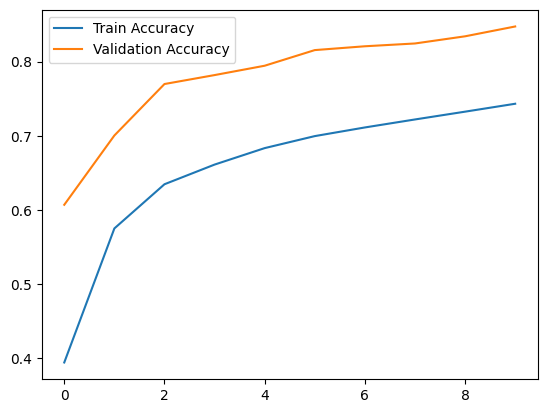

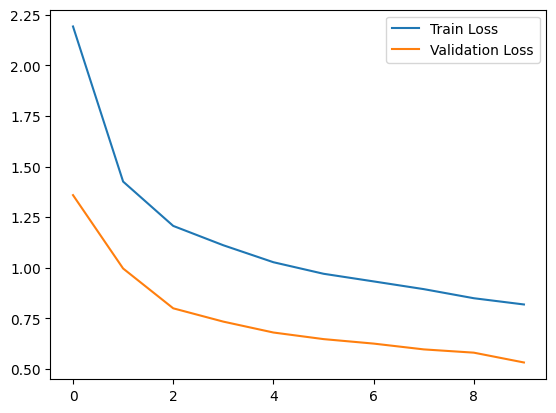

In [29]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


## Define function to make labels readable

In [2]:
# Extracts information from the label
def parse_label(label):
    # Split the label into the flower name and disease part
    label = label.split(" ")[0]
    parts = label.split("___")
    
    # Extract the flower name and make it human-readable
    flower_name = parts[0].replace("_", " ").replace("(", "").replace(")", "")
    
    # Determine if the label indicates a healthy plant
    is_healthy = "healthy" in label
    
    # Extract the disease name or mark it as healthy
    if is_healthy:
        disease = "healthy"
    else:
        disease = parts[1].replace("_", " ").replace("(", "").replace(")", "")
    
    return flower_name, is_healthy, disease

# Example usage

# print(parse_label("Corn_(maize)___Northern_Leaf_Blight"))
# print(parse_label("Cherry_(including_sour)___Powdery_mildew"))
# print(parse_label("Blueberry___healthy"))
# print(parse_label("Tomato___Spider_mites Two-spotted_spider_mite"))

import os

base_path = './split_dataset/test'
folder_names = os.listdir(base_path)  # List all items in the directory
folder_names = [folder for folder in folder_names if os.path.isdir(os.path.join(base_path, folder))]  # Keep only directories

result = []  # This will hold the nested list of results

for folder in folder_names:
    result.append(parse_label(folder))  # Apply the function and append to the result

print(result)




[('Apple', False, 'Apple scab'), ('Apple', False, 'Black rot'), ('Apple', False, 'Cedar apple rust'), ('Apple', True, 'healthy'), ('Blueberry', True, 'healthy'), ('Cherry including sour', True, 'healthy'), ('Cherry including sour', False, 'Powdery mildew'), ('Corn maize', False, 'Cercospora leaf spot'), ('Corn maize', False, 'Common rust '), ('Corn maize', True, 'healthy'), ('Corn maize', False, 'Northern Leaf Blight'), ('Grape', False, 'Black rot'), ('Grape', False, 'Esca Black Measles'), ('Grape', True, 'healthy'), ('Grape', False, 'Leaf blight Isariopsis Leaf Spot'), ('Orange', False, 'Haunglongbing Citrus greening'), ('Peach', False, 'Bacterial spot'), ('Peach', True, 'healthy'), ('Pepper, bell', False, 'Bacterial spot'), ('Pepper, bell', True, 'healthy'), ('Potato', False, 'Early blight'), ('Potato', True, 'healthy'), ('Potato', False, 'Late blight'), ('Raspberry', True, 'healthy'), ('Soybean', True, 'healthy'), ('Squash', False, 'Powdery mildew'), ('Strawberry', True, 'healthy'),

# Split model into parts

In [3]:

file_name = "model.keras"

def split_file(file_path, parts):
    with open(file_path, 'rb') as f:
        content = f.read()
    
    part_size = len(content) // parts
    for i in range(parts):
        start = i * part_size
        end = None if i == parts - 1 else (i + 1) * part_size
        with open(f"{file_path}.part{i+1}", 'wb') as part_file:
            part_file.write(content[start:end])

split_file(file_name, parts=3)



def merge_file(output_path, part_paths):
    with open(output_path, 'wb') as output:
        for part in part_paths:
            with open(part, 'rb') as part_file:
                output.write(part_file.read())

#merge_file("model_final_new.keras", ["model_final.keras.part1", "model_final.keras.part2", "model_final.keras.part3"])

